<a href="https://colab.research.google.com/github/seagalputra/fruit-classification/blob/master/fruit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit Classification using VGG16

Nama : Dwiferdio Seagal Putra

NIM : 1301154323

### 0. Preparation
Tahap awal sebelum memulai pembuatan model, diperlukan akses ke masing-masing *storage* dari *local* maupun *cloud*


---

Jika menggunakan Google Colab untuk menjalankan *notebook* ini, jalankan *cell* dibawah ini untuk mendapatkan akses ke google drive masing-masing

In [0]:
# Load drive helper and mount
from google.colab import drive

# Prompt authorization
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Dataset ditaruh pada folder "TUGAS_SISREK" (tanpa tanda kutip) dan di dalamnya terdapat folder data yang berisi data gambar serta dua buah file .npy yang memuat *array* dataset dan label.

In [0]:
!ls "/content/gdrive/My Drive/TUGAS_SISREK"

data  dataset.npy  label.npy


Import library yang dibutuhkan. Arsitektur VGG16 dibuat secara mandiri menggunakan library Keras. 

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.optimizers import SGD

### 1. Preprocessing data
Sebelum memulai pembangunan model, data diproses terlebih dahulu untuk memenuhi spesifikasi *input* dari VGG16. File .npy memuat array gambar berukuran 21287 dan setiap gambar berukuran 84x78x3 pixel serta memiliki label yang berjumlah 6. Arsitektur VGG16 memerlukan input gambar berukuran 224x224x3, sehingga diperlukan *resize* terhadap masing-masing gambar.

In [0]:
def label_to_num(label):
  '''
    Fungsi untuk melakukan konversi label dari string ke angka
  '''
  
  label_index = []
  fruits = ['apple', 'banana', 'lemon', 'lime', 'orange', 'peach', 'pear']

  for i in range(len(label)):
    if (label[i] == fruits[0]):
      label_index.append('0')
    elif (label[i] == fruits[1]):
      label_index.append('1')
    elif (label[i] == fruits[2]):
      label_index.append('2')
    elif (label[i] == fruits[3]):
      label_index.append('3')
    elif (label[i] == fruits[4]):
      label_index.append('4')
    elif (label[i] == fruits[5]):
      label_index.append('5')
    elif (label[i] == fruits[6]):
      label_index.append('6')
  
  return label_index

Load dataset dan label yang dibutuhkan. Jika file berada di *storage* lainnya, ganti variabel path_dataset dan path_label yang sesuai dengan tempat menyimpan dataset.

In [0]:
path_dataset = '/content/gdrive/My Drive/TUGAS_SISREK/dataset.npy'
path_label = '/content/gdrive/My Drive/TUGAS_SISREK/label.npy'

dataset = np.load(path_dataset)
label = np.load(path_label)

Lakukan plot gambar untuk memastikan bahwa dataset dan label telah diakses dengan benar.

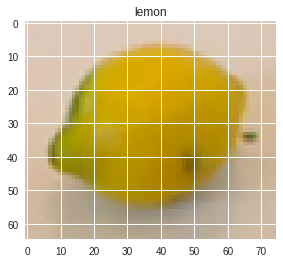

In [0]:
# Show image data
plt.imshow(dataset[3])
plt.title(label[3])
plt.show()

Untuk memenuhi spesifikasi input VGG16, dilakukan *resize* pada tiap-tiap gambar dengan ukuran 224x224x3.

In [0]:
# resize image into 224x224 pixel
img_data = []
for i in range(len(dataset)):
  img = cv2.resize(dataset[i], (224, 224))
  img_data.append(img)

img_data = np.asarray(img_data)
dataset = []

Konversi label dengan tipe data *string* menjadi *integer* yang nantinya diubah menjadi *categorical* sesuai dengan pra-syarat model.

In [0]:
label_index = label_to_num(label)
label_index = np.asarray(label_index)

Karena data yang digunakan masih berurutan, dilakukan pengacakan terhadap data tersebut. Fungsi dari pengacakan data tersebut agar model dapat mempelajari label yang bervariasi dan menghindari terjadinya *overfit*.

In [0]:
# shuffle dataset
shuffle_index = np.random.permutation(21287)
img_data, label_index = img_data[shuffle_index], label_index[shuffle_index]

Label diubah menjadi *categorical* karena model hanya mampu menerima label dengan inputan 0 atau 1

In [0]:
# change label to categorical
label_index = np_utils.to_categorical(label_index)

In [0]:
# check array size of image
img_data.shape

(21287, 224, 224, 3)

*Split* data menjadi data train dan data test yang nantinya digunakan untuk memvalidasi data tersebut.

In [0]:
# split data into data train and data test
X_train, X_test, y_train, y_test = train_test_split(img_data, label_index, test_size=0.33, shuffle=False)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14262, 224, 224, 3) (14262, 7) (7025, 224, 224, 3) (7025, 7)


### 2. Model Definition

![VGG16 Model Architecture](https://www.pyimagesearch.com/wp-content/uploads/2017/03/imagenet_vgg16.png)

Model yang digunakan yaitu VGG16. Model tersebut cenderung sederhana dan eksekusi tiap layer secara *sequential*. Dengan menggunakan 3x3 *convolutional layers* dan disusun secara bertumpuk. Layer tersebut juga direduksi menggunakan *max pooling layer*, dilanjutkan dengan menggunakan *fully-connected layers* berukuran 4096, lalu dilanjutkan oleh *softmax classifier* untuk mendapatkan kelas yang sesuai dengan label.

In [0]:
model = Sequential()

model.add(Conv2D(64, 3, activation='relu', input_shape=(224,224,3)))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(128, 3, activation='relu'))
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(256, 3, activation='relu'))
model.add(Conv2D(256, 3, activation='relu'))
model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(512, 3, activation='relu'))
model.add(Conv2D(512, 3, activation='relu'))
model.add(Conv2D(512, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(512, 3, activation='relu'))
model.add(Conv2D(512, 3, activation='relu'))
model.add(Conv2D(512, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(7, activation='softmax', name='predictions'))

Setelah model didefinisikan, model dikompilasi dan *optimizer* yang digunakan yaitu SGD.

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

### 3. Training Model
Model ditraining dengan *epochs* sebesar 50

In [0]:
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_split=0.33)

Train on 9555 samples, validate on 4707 samples
Epoch 1/50
9555/9555 [==============================] - 286s 30ms/step - loss: 0.3459 - acc: 0.8851 - val_loss: 0.0529 - val_acc: 0.9921
Epoch 2/50
9555/9555 [==============================] - 266s 28ms/step - loss: 0.0667 - acc: 0.9814 - val_loss: 0.9588 - val_acc: 0.7092
Epoch 3/50
9555/9555 [==============================] - 266s 28ms/step - loss: 0.0248 - acc: 0.9932 - val_loss: 0.2690 - val_acc: 0.9405
Epoch 4/50
9555/9555 [==============================] - 266s 28ms/step - loss: 0.0117 - acc: 0.9970 - val_loss: 0.2895 - val_acc: 0.9093
Epoch 5/50
9555/9555 [==============================] - 266s 28ms/step - loss: 0.0118 - acc: 0.9970 - val_loss: 0.0509 - val_acc: 0.9843
Epoch 6/50
9555/9555 [==============================] - 266s 28ms/step - loss: 0.0049 - acc: 0.9984 - val_loss: 0.2976 - val_acc: 0.9074
Epoch 7/50
9555/9555 [==============================] - 266s 28ms/step - loss: 0.0050 - acc: 0.9986 - val_loss: 0.0019 - val_acc: 

Hasil dari proses training tersebut didapatkan hasil prediksi, nilai *loss* dan akurasi dari model. Akurasi yang didapat dari proses training tersebut sebesar 100%.

In [0]:
loss, accuracy = model.evaluate(X_test, y_test)
print('Model loss : %s' %loss)
print('Model Accuracy : %s' %accuracy)

7025/7025 [==============================] - 60s 9ms/step
Model loss : 0.000530054899106267
Model Accuracy : 1.0


### 4. Predict and Plotting Model
Model diprediksi dari data testing yang telah didefinisikan sebelumnya. Hasil prediksi tersebut berupa nilai 0-6 yang merepresentasikan label dari tiap-tiap data. Agar hasil prediksi dapat menampilkan label sesuai dengan prediksi yang dihasilkan, diperlukan konversi dari nilai 0-6 menjadi label data yang bersesuaian.

In [0]:
# predict image
image_predict = model.predict(X_test).argmax(-1)

Enam pertama hasil dari prediksi ditampilkan untuk memvalidasi apakah prediksi dari model tersebut telah sesuai dengan data testing yang diberikan.

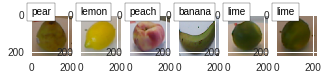

In [0]:
# plot image
columns = 7
rows = 1

for i in range(1, columns):
  img = X_test[i]
  if (image_predict[i] == 0):
    label_predict = 'apple'
  elif (image_predict[i] == 1):
    label_predict = 'banana'
  elif (image_predict[i] == 2):
    label_predict = 'lemon'
  elif (image_predict[i] == 3):
    label_predict = 'lime'
  elif (image_predict[i] == 4):
    label_predict = 'orange'
  elif (image_predict[i] == 5):
    label_predict = 'peach'
  elif (image_predict[i] == 6):
    label_predict = 'pear'
  
  plt.subplot(rows, columns, i)
  plt.imshow(img)
  plt.text(0, 0, s=label_predict, color='black', bbox=dict(facecolor='white', alpha=1))
  
plt.show()

### 5. Conclusion
Berdasarkan percobaan diatas, didapatkan akurasi sebesar 100% dengan menggunakan *fruit dataset* dan VGG16 model. Hasil tersebut setara dengan tugas 3 yang menggunakan descriptor HoG dan kNN. Namun, komputasi menggunakan VGG16 lebih lama karena bergantung dari banyaknya layer yang digunakan dan juga *epochs*

### 6. Future Works
Dengan mengganti arsitektur CNN yang lebih ringan seperti SqueezeNet atau DenseNet diharapkan dapat mengurangi waktu komputasi yang cenderung berat jika menggunakan VGG16